
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 82.8 MB/s eta 0:00:00
Thu Sep  4 10:22:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W 

Import necessary packages.

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [3]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        state_shape  = (buffer_size, state_dims)  if isinstance(state_dims, int)  else (buffer_size, *state_dims)
        action_shape = (buffer_size, action_dims) if isinstance(action_dims, int) else (buffer_size, *action_dims)

        self.state_memory      = np.zeros(state_shape,  dtype=np.float32)
        self.next_state_memory = np.zeros(state_shape,  dtype=np.float32)
        self.action_memory     = np.zeros(action_shape, dtype=np.float32)
        self.reward_memory     = np.zeros((buffer_size,), dtype=np.float32)
        self.done_memory       = np.zeros((buffer_size,), dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        """Store one transition."""
        index = self.ptr
        self.state_memory[index]      = state
        self.next_state_memory[index] = state_
        self.action_memory[index]     = action
        self.reward_memory[index]     = reward
        self.done_memory[index]       = float(done)

        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        """Sample a random batch."""
        max_mem = self.buffer_size if self.is_full else self.ptr
        sample_size = min(batch_size, max_mem)
        batch_idx   = np.random.choice(max_mem, sample_size, replace=False)

        states  = T.tensor(self.state_memory[batch_idx],      dtype=T.float32)
        actions = T.tensor(self.action_memory[batch_idx],     dtype=T.float32)
        rewards = T.tensor(self.reward_memory[batch_idx],     dtype=T.float32).unsqueeze(-1)
        states_ = T.tensor(self.next_state_memory[batch_idx], dtype=T.float32)
        done    = T.tensor(self.done_memory[batch_idx],       dtype=T.float32).unsqueeze(-1)

        return states, actions, rewards, states_, done


## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [5]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.state_dims  = state_dims if isinstance(state_dims, int) else int(np.prod(state_dims))
        self.action_dims = action_dims if isinstance(action_dims, int) else int(np.prod(action_dims))
        self.fc1_dims    = fc1_dims
        self.fc2_dims    = fc2_dims
        self.name        = name
        self.ckpt_dir    = ckpt_dir
        self.ckpt_path   = os.path.join(ckpt_dir, name + '_sac.pt')
        self.device      = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define the first fully connected layer
        self.fc1 = nn.Linear(self.state_dims + self.action_dims, fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q   = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.state_dims   = state_dims if isinstance(state_dims, int) else int(np.prod(state_dims))
        self.action_dims  = action_dims if isinstance(action_dims, int) else int(np.prod(action_dims))
        self.fc1_dims     = fc1_dims
        self.fc2_dims     = fc2_dims
        self.max_action   = float(max_action)
        self.reparam_eps  = float(reparam_noise) 
        self.name         = name
        self.ckpt_dir     = ckpt_dir
        self.ckpt_path    = os.path.join(ckpt_dir, name + '_sac.pt')
        self.device       = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(self.state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu_head      = nn.Linear(fc2_dims, self.action_dims)
        self.log_std_head = nn.Linear(fc2_dims, self.action_dims)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)

    def forward(self, state):
        #TODO
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        log_std = self.log_std_head(x)
        log_std = T.clamp(log_std, min=-20.0, max=2.0)
        sigma = T.exp(log_std)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)

        # TODO 8: Create a normal distribution and sample from it
        dist = Normal(mu, sigma)
        z = dist.rsample() if reparameterize else dist.sample()

        y = T.tanh(z)
        action = y * self.max_action

        log_probs = dist.log_prob(z) - T.log(1 - y.pow(2) + 1e-6)
        log_probs = log_probs.sum(dim=1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.state_dims = state_dims if isinstance(state_dims, int) else int(np.prod(state_dims))
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims
        self.name       = name
        self.ckpt_dir   = ckpt_dir
        self.ckpt_path  = os.path.join(ckpt_dir, name + '_sac.pt')
        self.device     = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(self.state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v   = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [12]:
class Agent:
    def __init__(self, gamma, alpha, beta,
                 state_dims, action_dims, max_action,
                 fc1_dim, fc2_dim,
                 memory_size, batch_size,
                 tau, update_period,
                 reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):

        self.gamma = gamma
        self.alpha = alpha
        self.beta  = beta

        self.state_dims  = state_dims
        self.action_dims = action_dims
        self.max_action  = max_action

        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim

        self.memory_size    = memory_size
        self.batch_size     = batch_size
        self.tau            = tau
        self.update_period  = update_period
        self.reward_scale   = reward_scale
        self.warmup         = warmup if warmup is not None else 0
        self.reparam_noise_lim = reparam_noise_lim

        self.name     = name
        self.ckpt_dir = ckpt_dir

        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        model_name = (
            f'{name}__'
            f'gamma_{gamma:.2f}__alpha_{alpha:.4f}__beta_{beta:.4f}__'
            f'fc1_{fc1_dim}__fc2_{fc2_dim}__bs_{batch_size}__'
            f'buffer_{memory_size}__update_period_{update_period}__tau_{tau:.3f}__'
        )
        self.model_name = model_name
        self.full_path  = os.path.join(self.ckpt_dir, self.model_name)

        os.makedirs(self.full_path, exist_ok=True)

        self.learn_iter = 0

        self.memory = ReplayBuffer(self.memory_size, self.state_dims, self.action_dims)

        self.critic_1 = Critic(beta, self.state_dims, self.action_dims,
                               self.fc1_dim, self.fc2_dim,
                               name='Critic_1', ckpt_dir=self.full_path).to(self.device)

        self.critic_2 = Critic(beta, self.state_dims, self.action_dims,
                               self.fc1_dim, self.fc2_dim,
                               name='Critic_2', ckpt_dir=self.full_path).to(self.device)

        self.value = Value(beta, self.state_dims,
                           self.fc1_dim, self.fc2_dim,
                           name='Value', ckpt_dir=self.full_path).to(self.device)

        self.target_value = Value(beta, self.state_dims,
                                  self.fc1_dim, self.fc2_dim,
                                  name='TargetValue', ckpt_dir=self.full_path).to(self.device)

        self.actor = Actor(alpha, self.state_dims, self.action_dims,
                           self.fc1_dim, self.fc2_dim,
                           self.max_action, self.reparam_noise_lim,
                           name='Actor', ckpt_dir=self.full_path).to(self.device)

        self.update_parameters(tau=1.0)


    def choose_action(self, state, deterministic=False, reparameterize=False):
        """
        state: np.ndarray of shape (state_dims,)
        returns: np.ndarray of shape (action_dims,)
        """
        self.actor.eval()
        with T.no_grad():
            s = T.tensor(state, dtype=T.float32, device=self.device).unsqueeze(0)

            if deterministic:
                mu, _ = self.actor(s)                          
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(s, reparameterize=reparameterize)

        self.actor.train()
        return action.squeeze(0).detach().cpu().numpy()

   
    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        s, a, r, s_, d = self.memory.load_batch(self.batch_size)

        s  = T.tensor(s,  dtype=T.float32, device=self.device)
        a  = T.tensor(a,  dtype=T.float32, device=self.device)
        r  = T.tensor(r,  dtype=T.float32, device=self.device).view(-1, 1)
        s_ = T.tensor(s_, dtype=T.float32, device=self.device)
        d  = T.tensor(d,  dtype=T.float32, device=self.device).view(-1, 1)

        return s, a, r, s_, d


    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        for target_param, param in zip(self.target_value.parameters(),
                                       self.value.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def save_model(self):
        os.makedirs(self.full_path, exist_ok=True)
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        if self.memory.ptr < self.batch_size:
            return
        if self.learn_iter < self.warmup:
            self.learn_iter += 1
            return
        if self.learn_iter % self.update_period != 0:
            self.learn_iter += 1
            return

        states, actions, rewards, states_, dones = self.load_batch()

        with T.no_grad():
            new_actions_v, log_probs_v = self.actor.sample_normal(states, reparameterize=False)
            q1_v = self.critic_1(states, new_actions_v)
            q2_v = self.critic_2(states, new_actions_v)
            q_v  = T.min(q1_v, q2_v)

        v_pred = self.value(states)
        v_target = q_v - self.alpha * log_probs_v.unsqueeze(-1)
        value_loss = F.mse_loss(v_pred, v_target)

        self.value.optimizer.zero_grad(set_to_none=True)
        value_loss.backward()
        self.value.optimizer.step()

        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_pi = self.critic_1(states, new_actions)
        q2_pi = self.critic_2(states, new_actions)
        q_pi  = T.min(q1_pi, q2_pi)

        actor_loss = (self.alpha * log_probs.unsqueeze(-1) - q_pi).mean()

        self.actor.optimizer.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor.optimizer.step()

        with T.no_grad():
            v_next = self.target_value(states_)
            q_hat  = self.reward_scale * rewards + self.gamma * (1.0 - dones) * v_next

        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)

        critic1_loss = F.mse_loss(q1, q_hat)
        critic2_loss = F.mse_loss(q2, q_hat)

        self.critic_1.optimizer.zero_grad(set_to_none=True)
        critic1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad(set_to_none=True)
        critic2_loss.backward()
        self.critic_2.optimizer.step()

        self.update_parameters(self.tau)

        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [13]:
env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'

n_games = 300

gamma = 0.99
alpha = 3e-4
beta  = 3e-4
fc1_dim = 256
fc2_dim = 256

memory_size = 1_000_000
batch_size  = 256
tau = 0.005
update_period = 2
reward_scale = 2.0

warmup = 10_000

reparam_noise_lim = 1e-6
record_video = True


## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/300 [00:00<?, ?it/s]

| Game:      0 | Score:   -1300.06 | Best score:       -inf | Avg score   -1300.06 | Learning iter:        745 |
... saving checkpoint ...
| Game:      1 | Score:   -1086.96 | Best score:   -1300.06 | Avg score   -1193.51 | Learning iter:       1745 |
... saving checkpoint ...
| Game:      2 | Score:   -1179.83 | Best score:   -1193.51 | Avg score   -1188.95 | Learning iter:       2745 |
... saving checkpoint ...
| Game:      3 | Score:   -1317.59 | Best score:   -1188.95 | Avg score   -1221.11 | Learning iter:       3745 |
| Game:      4 | Score:   -1157.04 | Best score:   -1188.95 | Avg score   -1208.30 | Learning iter:       4745 |
| Game:      5 | Score:   -1372.87 | Best score:   -1188.95 | Avg score   -1235.73 | Learning iter:       5745 |
| Game:      6 | Score:   -1283.50 | Best score:   -1188.95 | Avg score   -1242.55 | Learning iter:       6745 |
| Game:      7 | Score:   -1223.97 | Best score:   -1188.95 | Avg score   -1240.23 | Learning iter:       7745 |
| Game:      8 | S

/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:67: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment HalfCheetahBulletEnv-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:149: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argum

| Game:    298 | Score:     891.06 | Best score:     659.76 | Avg score     661.30 | Learning iter:     298745 |
... saving checkpoint ...


/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


| Game:    299 | Score:     779.64 | Best score:     661.30 | Avg score     661.75 | Learning iter:     299745 |
... saving checkpoint ...


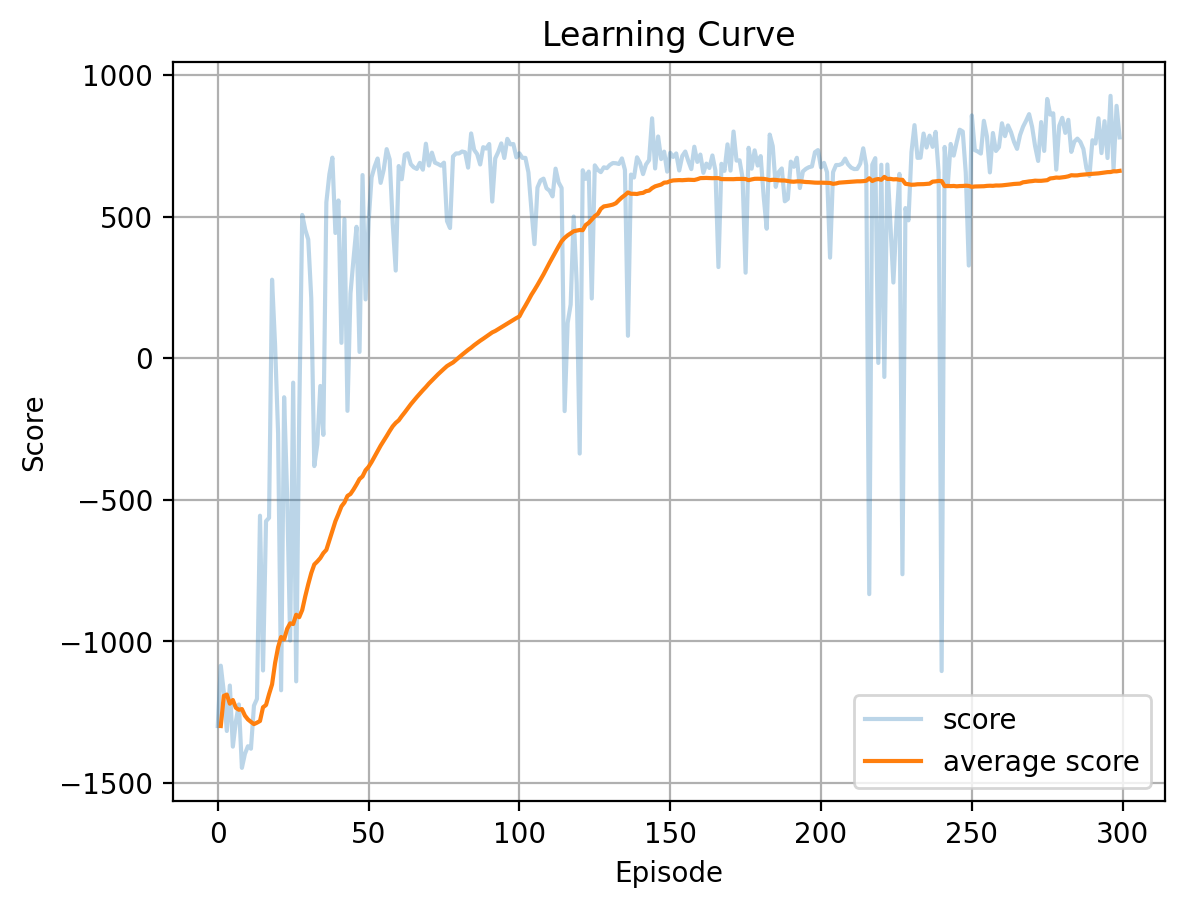

In [14]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(
        env,
        video_folder=os.path.join(dir_path, 'videos'),
        episode_trigger=lambda ep: ep == (n_games if n_games is not None else 0) - 1
    )

state_dims  = int(np.prod(env.observation_space.shape))
action_dims = int(np.prod(env.action_space.shape))
max_action  = float(np.abs(env.action_space.high[0]))

n_games      = 300 if n_games is None else n_games
memory_size  = 1_000_000 if memory_size is None else memory_size
batch_size   = 256 if batch_size is None else batch_size
warmup       = 10_000 if warmup is None else warmup

agent = Agent(
    gamma=gamma, alpha=alpha, beta=beta,
    state_dims=state_dims, action_dims=action_dims, max_action=max_action,
    fc1_dim=fc1_dim, fc2_dim=fc2_dim,
    memory_size=memory_size, batch_size=batch_size,
    tau=tau, update_period=update_period,
    reward_scale=reward_scale, warmup=warmup,
    reparam_noise_lim=reparam_noise_lim,
    name='SAC', ckpt_dir=dir_path
)

# TODO: Initialize performance tracking variables
best_score = -np.inf
scores = []
avg_score = 0.0

for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    out = env.reset()
    state = out[0] if isinstance(out, tuple) else out
    done = False
    score = 0.0

    # TODO: Interact with the environment until the episode is done
    while not done:
        action = agent.choose_action(state, deterministic=False, reparameterize=False)

        step_out = env.step(action)
        if len(step_out) == 5:  
            state_, reward, terminated, truncated, _ = step_out
            done = terminated or truncated
        else:  
            state_, reward, done, _ = step_out

        agent.store_transition(state, action, reward, state_, float(done))
        agent.learn()

        score += reward
        state = state_

    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    # TODO: Save the model if the current avg score is better than the best so far
    if avg_score > best_score:
        best_score = avg_score
        agent.save_model()

env.close()

plot_learning_curve(scores, agent.full_path)


## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [15]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)